<a href="https://www.kaggle.com/code/jiwasambhuwara/food-scan-using-resnet50?scriptVersionId=133937169" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Food Scan Using ResNet50

 # Import Modules & Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.metrics import categorical_crossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import os
import random
import numpy as np
import PIL
from PIL import Image
import pandas as pd
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sns

# Set Up HyperParameter

In [2]:
height = 224
width = 224
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

# Create Dataset and Preprocessing Dataset

In [3]:
TRAINING_DIR = "/kaggle/input/d/jiwasambhuwara/food-ingredients/Food Dataset/train"
VALIDATION_DIR = "/kaggle/input/d/jiwasambhuwara/food-ingredients/Food Dataset/val"
TEST_DIR = "/kaggle/input/d/jiwasambhuwara/food-ingredients/Food Dataset/test"

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DIR,
    labels='inferred',
    color_mode='rgb',
    label_mode='int',
    shuffle=True,
    image_size=img_size,
    batch_size=batch_size,
    seed=123
    )

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    shuffle=False,
    image_size=img_size,
    batch_size=batch_size,
    )

labels = train_ds.class_names
print(labels)

with open('food_label.txt', 'w') as f:
    for food_class in labels:
        f.write(f'{food_class}\n')

Found 20038 files belonging to 54 classes.
Found 5179 files belonging to 54 classes.
['Alpukat', 'Anggur', 'Apel', 'Asparagus', 'Brokoli', 'Buah naga', 'Ceker ayam', 'Dada ayam', 'Durian', 'Jagung', 'Jambu Air', 'Jeruk', 'Kacang Mete', 'Kacang polong', 'Kacang tanah', 'Kangkung', 'Kelapa', 'Kembang Kol', 'Kentang', 'Klengkeng', 'Labu', 'Labu Siam', 'Leci', 'Lemon', 'Lobak Merah', 'Mangga', 'Melon', 'Mentimun', 'Nanas', 'Nangka', 'Nasi merah', 'Nasi putih', 'Paha bawah ayam', 'Paprika', 'Pare', 'Pepaya', 'Pir', 'Pisang', 'Pokcoy', 'Pork belly', 'Rambutan', 'Salmon', 'Sayap Ayam', 'Semangka', 'Singkong', 'Stroberi', 'Tahu', 'Tauge', 'Telur', 'Tempe', 'Terong', 'Tomat', 'Ubi', 'Wortel']


In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(TEST_DIR,
                                                     labels = 'inferred',
                                                     label_mode = 'int',
                                                     image_size = img_size,
                                                     shuffle = False
                                                    )

Found 2574 files belonging to 54 classes.


In [6]:
test_labels = test_ds.class_names
print(test_labels)

['Alpukat', 'Anggur', 'Apel', 'Asparagus', 'Brokoli', 'Buah naga', 'Ceker ayam', 'Dada ayam', 'Durian', 'Jagung', 'Jambu Air', 'Jeruk', 'Kacang Mete', 'Kacang polong', 'Kacang tanah', 'Kangkung', 'Kelapa', 'Kembang Kol', 'Kentang', 'Klengkeng', 'Labu', 'Labu Siam', 'Leci', 'Lemon', 'Lobak Merah', 'Mangga', 'Melon', 'Mentimun', 'Nanas', 'Nangka', 'Nasi merah', 'Nasi putih', 'Paha bawah ayam', 'Paprika', 'Pare', 'Pepaya', 'Pir', 'Pisang', 'Pokcoy', 'Pork belly', 'Rambutan', 'Salmon', 'Sayap Ayam', 'Semangka', 'Singkong', 'Stroberi', 'Tahu', 'Tauge', 'Telur', 'Tempe', 'Terong', 'Tomat', 'Ubi', 'Wortel']


## **Show Data Sample**

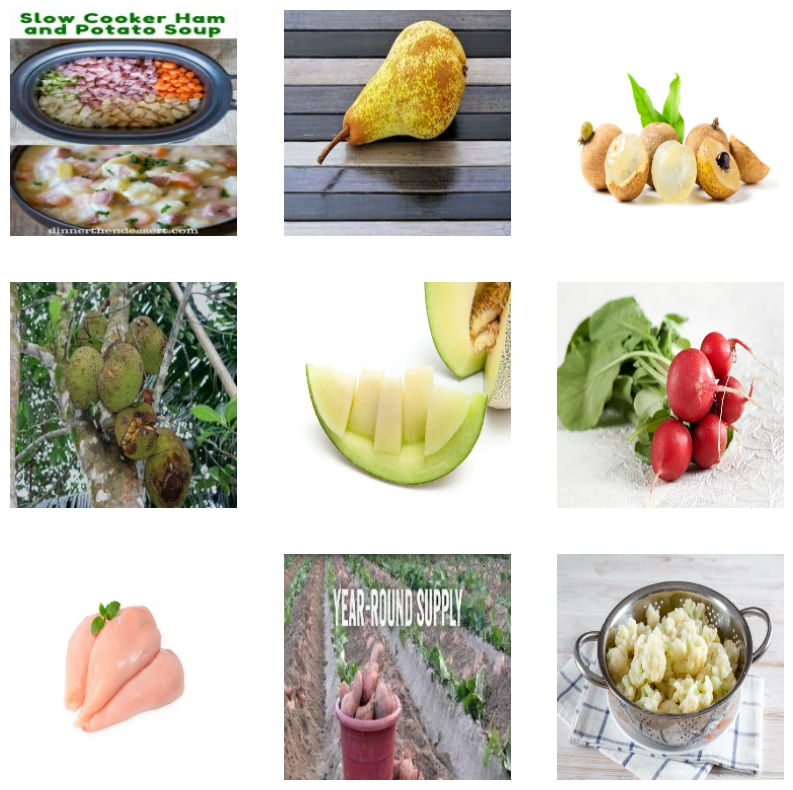

In [7]:
plt.figure(figsize=(10, 10))
for images, train_ds.class_names in train_ds.take(1): 
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## Augment Dataset and Normalize Dataset

In [8]:
#rescale = tf.keras.Sequential([
    #layers.Rescaling(1./255)
#])
#data_augmentation = tf.keras.Sequential([
    #layers.RandomFlip("horizontal_and_vertical"),
    #layers.RandomRotation(0.2),
    #layers.RandomZoom(0.2),
#])

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
import numpy as np

# Mengambil satu batch dari dataset
image_batch, _ = next(iter(normalized_test_ds))

# Mengambil gambar pertama dari batch
first_image = image_batch[0]

# Mencetak nilai piksel minimum dan maksimum pada gambar pertama
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Create and Compile Model ResNet50

In [12]:
def create_model1(pretrained_model1):
        preprocessing_layer = tf.keras.applications.resnet.preprocess_input
        inputs = pretrained_model1.input
        resnet_output = pretrained_model1.output
        
        x = preprocessing_layer(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Flatten()(resnet_output)

        x = tf.keras.layers.Dense(32, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        
        #x = tf.keras.layers.Dense(512, activation='relu')(x)
        #x = tf.keras.layers.Dropout(0.2)(x)
        
        x = tf.keras.layers.BatchNormalization()(x)
        
        outputs = tf.keras.layers.Dense(55, activation='softmax')(x)

        model1 = tf.keras.Model(inputs, outputs)

        model1.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        return model1

pretrained_model1 = tf.keras.applications.xception.Xception(input_shape=img_shape,
                                                          include_top=False,
                                                          weights='imagenet',
                                                          pooling='avg'
                                                         )

model1 = create_model1(pretrained_model1)
model1.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                      

## **Train Dataset**

In [13]:
current_datetime = datetime.now()
#class myCallback(tf.keras.callbacks.Callback):
    #def on_epoch_end(self, epoch, logs={}):
        #if (logs.get('val_accuracy') > 0.90 and epoch > 3):
            #self.model.stop_training = True

# EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=False)

# ModelCheckpoint callback untuk menyimpan model dengan performa terbaik
#model_checkpoint_callback = ModelCheckpoint(f'best_model_{current_datetime}.h5', monitor='val_loss', mode='min', save_best_only=True)
            


history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=32,
    batch_size=batch_size,
    callbacks=[early_stopping_callback]    
        )

Epoch 1/32
627/627 [==============================] - 222s 301ms/step - loss: 2.9345 - accuracy: 0.2801 - val_loss: 2.2219 - val_accuracy: 0.4466
Epoch 2/32
627/627 [==============================] - 180s 286ms/step - loss: 1.6418 - accuracy: 0.5811 - val_loss: 1.9881 - val_accuracy: 0.5175
Epoch 3/32
627/627 [==============================] - 180s 286ms/step - loss: 1.1489 - accuracy: 0.7106 - val_loss: 1.5046 - val_accuracy: 0.6376
Epoch 4/32
627/627 [==============================] - 180s 286ms/step - loss: 0.9273 - accuracy: 0.7679 - val_loss: 0.8183 - val_accuracy: 0.7988
Epoch 5/32
627/627 [==============================] - 180s 287ms/step - loss: 0.7561 - accuracy: 0.8141 - val_loss: 1.0520 - val_accuracy: 0.7492
Epoch 6/32
627/627 [==============================] - 180s 286ms/step - loss: 0.6403 - accuracy: 0.8461 - val_loss: 0.7433 - val_accuracy: 0.8222
Epoch 7/32
627/627 [==============================] - 180s 286ms/step - loss: 0.5579 - accuracy: 0.8635 - val_loss: 0.9677 -

# Plot The Result

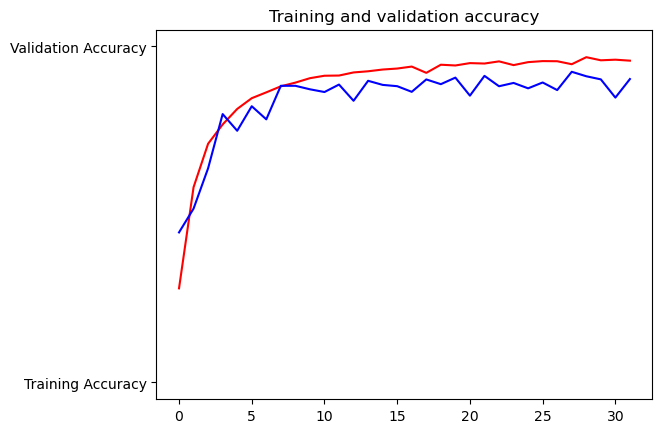

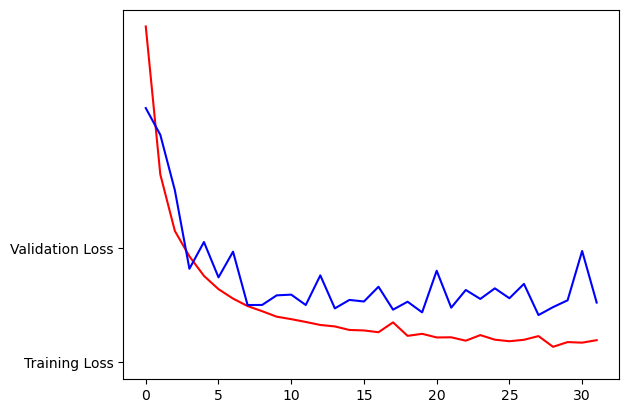

In [14]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

# Save Model and Convert to TFLite

In [15]:
current_datetime = datetime.now()
current_datetime

datetime.datetime(2023, 6, 17, 20, 25, 33, 888133)

In [16]:
current_datetime = datetime.now()
#model = tf.keras.models.load_model(f'best_model_{current_datetime}.h5')

# Save Model
model1.save(f'food_{current_datetime}')

# Save .h5 model
model1.save(f'food_{current_datetime}.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()

# Save the tflite model
with open(f'food_best_model_{current_datetime}.tflite', 'wb') as f:
    f.write(tflite_model)

# Save Model History

In [17]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = f'history{current_datetime}.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Zip Folder

In [18]:
#!zip -r "/kaggle/working/food_model_2023-04-20 07:28:30.zip" "/kaggle/working/food_model_2023-04-25 04:15:09.196917"

# Test Model

In [19]:
model1.evaluate(test_ds)

81/81 [==============================] - 14s 172ms/step - loss: 0.5306 - accuracy: 0.9040


[0.5306309461593628, 0.9040403962135315]

## **Confusion Matrix**

1/1 [==============================] - 1s 835ms/step


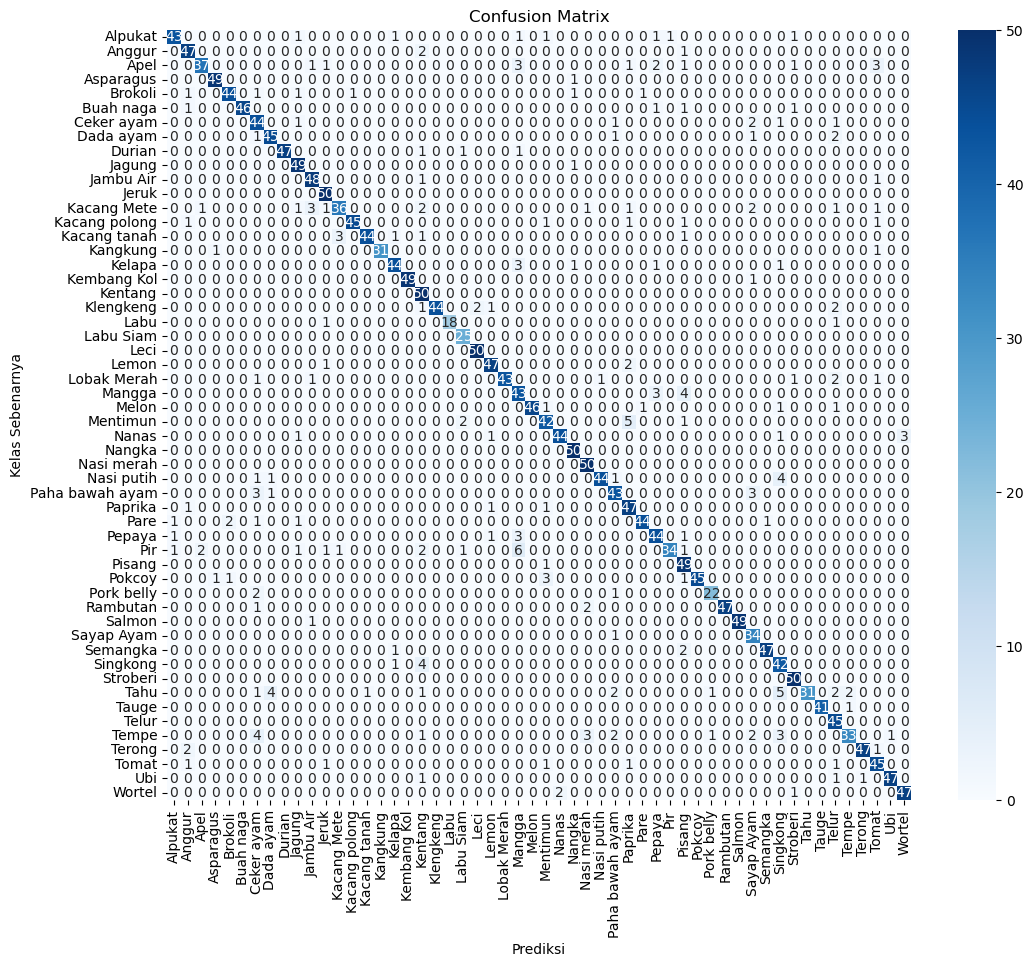

In [20]:
# Mendapatkan daftar label dari file 'food_label.txt'
with open('food_label.txt', 'r') as f:
    daftar_label = f.read().splitlines()

# Menyiapkan array untuk menyimpan label sebenarnya dan prediksi
kelas_sebenarnya = []
prediksi_label = []

# Meloop dataset uji dan mendapatkan prediksi dan label sebenarnya
for x, y in test_ds:
    prediksi = model1.predict(x)
    prediksi_label.extend(np.argmax(prediksi, axis=1))
    kelas_sebenarnya.extend(np.squeeze(y.numpy()))

# Menghitung confusion matrix
cm = confusion_matrix(kelas_sebenarnya, prediksi_label)

# Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=daftar_label, yticklabels=daftar_label)
plt.xlabel("Prediksi")
plt.ylabel("Kelas Sebenarnya")
plt.title("Confusion Matrix")
plt.show()

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Menghitung precision, recall, dan F1 score
precision = precision_score(kelas_sebenarnya, prediksi_label, average='macro')
recall = recall_score(kelas_sebenarnya, prediksi_label, average='macro')
f1 = f1_score(kelas_sebenarnya, prediksi_label, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.913511638687875
Recall: 0.9056616305093566
F1 Score: 0.9047767704640298


## **Manual Testing**

Apel/197.jpg
1/1 [==============================] - 1s 1s/step
[6.84716331e-04 5.17083899e-05 1.76615175e-02 1.89727666e-06
 1.74854006e-06 7.64962078e-06 4.26759819e-08 1.29611999e-06
 4.58606650e-07 1.74460001e-05 7.44935387e-05 1.61199248e-04
 2.49504019e-03 2.45606643e-04 3.47140281e-06 6.63239143e-06
 3.13601107e-04 3.80125940e-08 5.09392179e-04 5.20731592e-05
 2.83308191e-06 8.17594933e-04 2.66927600e-06 1.74631699e-04
 5.20470967e-05 8.51081371e-01 4.28037893e-05 4.54506917e-05
 2.59171702e-06 1.02440928e-04 5.53058317e-06 2.60596335e-06
 7.79650975e-08 2.77683248e-05 8.04556294e-06 2.55172374e-04
 1.24553196e-01 3.54718304e-06 8.40443772e-06 2.47182527e-07
 5.63855156e-06 1.48700892e-07 3.18994495e-07 4.43894860e-05
 7.59013744e-07 1.73390999e-05 9.81541007e-07 3.41008454e-05
 1.37799188e-05 9.85166207e-06 8.28797602e-06 3.77850083e-04
 7.30438842e-06 1.52689012e-07 4.29363531e-08]
predicted food: Mangga 
confidence: 0.851081371307373 


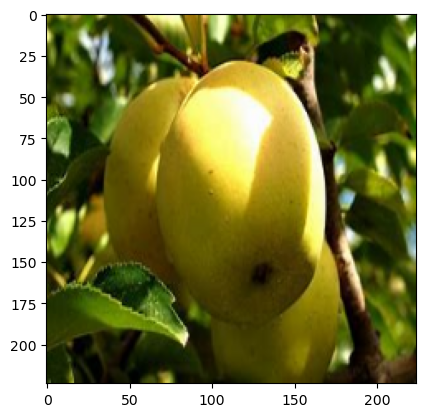

In [22]:
import cv2
random_classes_names = random.choice(os.listdir('/kaggle/input/d/jiwasambhuwara/food-ingredients/Food Dataset/test'))
random_file = random.choice(os.listdir(f'/kaggle/input/d/jiwasambhuwara/food-ingredients/Food Dataset/test/{random_classes_names}'))
print(f'{random_classes_names}/{random_file}')

img_test = cv2.imread(f'/kaggle/input/d/jiwasambhuwara/food-ingredients/Food Dataset/test/{random_classes_names}/{random_file}')
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (img_size))
plt.imshow(img_test)


prediction = model1.predict(np.expand_dims(img_test, axis=0))[0]
predicted_label = np.argmax(prediction)

print(prediction)
print(f'predicted food: {labels[predicted_label]} \nconfidence: {prediction[predicted_label]} ')